In [1]:
#Importing Keras packages
from __future__ import print_function
import os
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras import optimizers
from tensorflow.keras.preprocessing import image
from keras.layers.advanced_activations import ELU, LeakyReLU, PReLU, Softmax, ReLU
from keras.regularizers import l2
from tensorflow.keras import initializers

Using TensorFlow backend.


['test1', 'train']


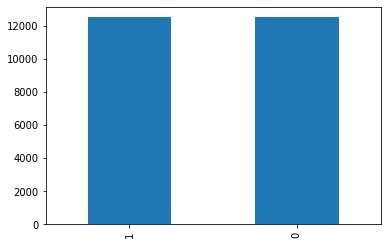

In [2]:
#Data Pre-processing and Inspection
import numpy as np
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
print(os.listdir("C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\CatsVsDogs\\catsvsdogs_images\\"))

image_width = 128
image_height = 128
image_size = (image_width, image_height)
image_channels = 3

input_shape = (image_width, image_height, image_channels)

filenames = os.listdir("C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\CatsVsDogs\\catsvsdogs_images\\train\\")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df['category'].value_counts().plot.bar()

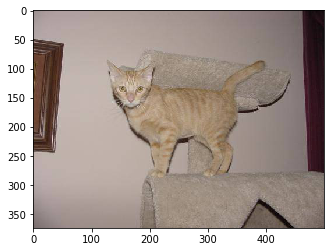

In [3]:
sample = random.choice(filenames)
image = load_img("C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\CatsVsDogs\\catsvsdogs_images\\train\\"+sample)
plt.imshow(image)

In [4]:
#Ensuring the model is built on the existing GPU
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1
physical_devices------------- 1


In [5]:
from keras.applications import VGG16

img_rows = 128
img_cols = 128 

#Loads the VGG16 model without the top or FC layers
vgg16 = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

for layer in vgg16.layers:
    layer.trainable = False

for (i,layer) in enumerate(vgg16.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [6]:
#Building ontop of the freezed layers
def addTopModel(bottom_model, num_classes, D = 512):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "elu")(top_model)
    top_model = Dropout(0.25)(top_model)
    top_model = Dense(1, activation = "sigmoid")(top_model)
    return top_model

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 2

FC_Head = addTopModel(vgg16, num_classes)

model = Model(inputs = vgg16.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [8]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as ts
                     
checkpoint = ModelCheckpoint("C:\\Users\\Admin\\Desktop\\Research\\Results\\VGGNet Results\\CatsAndDogs_VGGNet_ELU_ADAM.h5",
                             monitor = "val_loss",
                             mode = "min",
                             save_best_only = True,
                             verbose = 1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 9,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.25,
                              patience = 2,
                              verbose = 1,
                              min_delta = 0.00001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'binary_crossentropy',
              optimizer =  keras.optimizers.Adam(lr = 0.001),
              metrics = ['accuracy'])


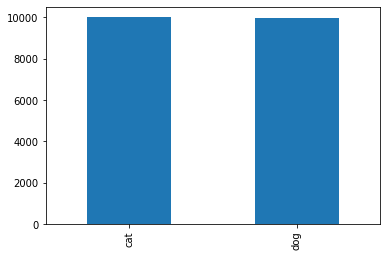

In [9]:
#Data distribution
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})
train_df, validate_df = train_test_split(df, test_size = 0.20, random_state = 42)
train_df = train_df.reset_index(drop = True)
validate_df = validate_df.reset_index(drop = True)
train_df['category'].value_counts().plot.bar()
validate_df['category'].value_counts().plot.bar()

In [10]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [11]:
batch_size = 32

In [12]:
#Data Augmentation setup
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\CatsVsDogs\\catsvsdogs_images\\train\\", 
    x_col = 'filename',
    y_col = 'category',
    target_size = image_size,
    class_mode = 'binary',
    batch_size = batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [13]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\CatsVsDogs\\catsvsdogs_images\\train\\", 
    x_col = 'filename',
    y_col = 'category',
    target_size = image_size,
    class_mode = 'binary',
    batch_size = batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [14]:
#Model testing
epochs = 20
history = model.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks
)

loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers = 12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))
model.save_weights("C:\\Users\\Admin\\Desktop\\Research\\Results\\VGGNet Results\\Weights\\CatsAndDogs_VGGNet_ELU_ADAM.h5")

Epoch 1/20
625/625 [==============================] - 89s 143ms/step - loss: 0.3897 - accuracy: 0.8313 - val_loss: 0.2324 - val_accuracy: 0.8904

Epoch 00001: val_loss improved from inf to 0.23240, saving model to C:\Users\Admin\Desktop\Research\Results\VGGNet Results\CatsAndDogs_VGGNet_ELU_ADAM.h5
Epoch 2/20
625/625 [==============================] - 88s 141ms/step - loss: 0.3158 - accuracy: 0.8622 - val_loss: 0.3273 - val_accuracy: 0.8784

Epoch 00002: val_loss did not improve from 0.23240
Epoch 3/20
625/625 [==============================] - 87s 140ms/step - loss: 0.2923 - accuracy: 0.8727 - val_loss: 0.2362 - val_accuracy: 0.8957

Epoch 00003: val_loss did not improve from 0.23240

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 4/20
625/625 [==============================] - 87s 140ms/step - loss: 0.2522 - accuracy: 0.8931 - val_loss: 0.2504 - val_accuracy: 0.8953

Epoch 00004: val_loss did not improve from 0.23240
Epoch 5/20
625/625 [========

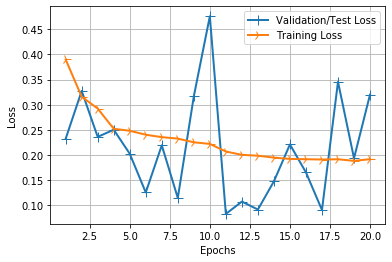

In [15]:
#Evaluating training and test error
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')
plt.setp(line1, linewidth = 2.0, marker = '+', markersize = 10.0)
plt.setp(line2, linewidth = 2.0, marker = '4', markersize = 10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [16]:
#Model Testing
test_filenames = os.listdir("C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\CatsVsDogs\\catsvsdogs_images\\test1\\")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [17]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\CatsVsDogs\\catsvsdogs_images\\test1\\", 
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = image_size,
    batch_size = batch_size,
    shuffle = False
)

Found 12500 validated image filenames.


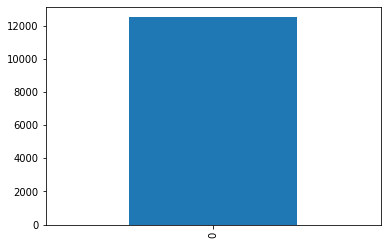

In [18]:
predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))
test_df['category'] = np.argmax(predict, axis = -1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })
test_df['category'].value_counts().plot.bar()

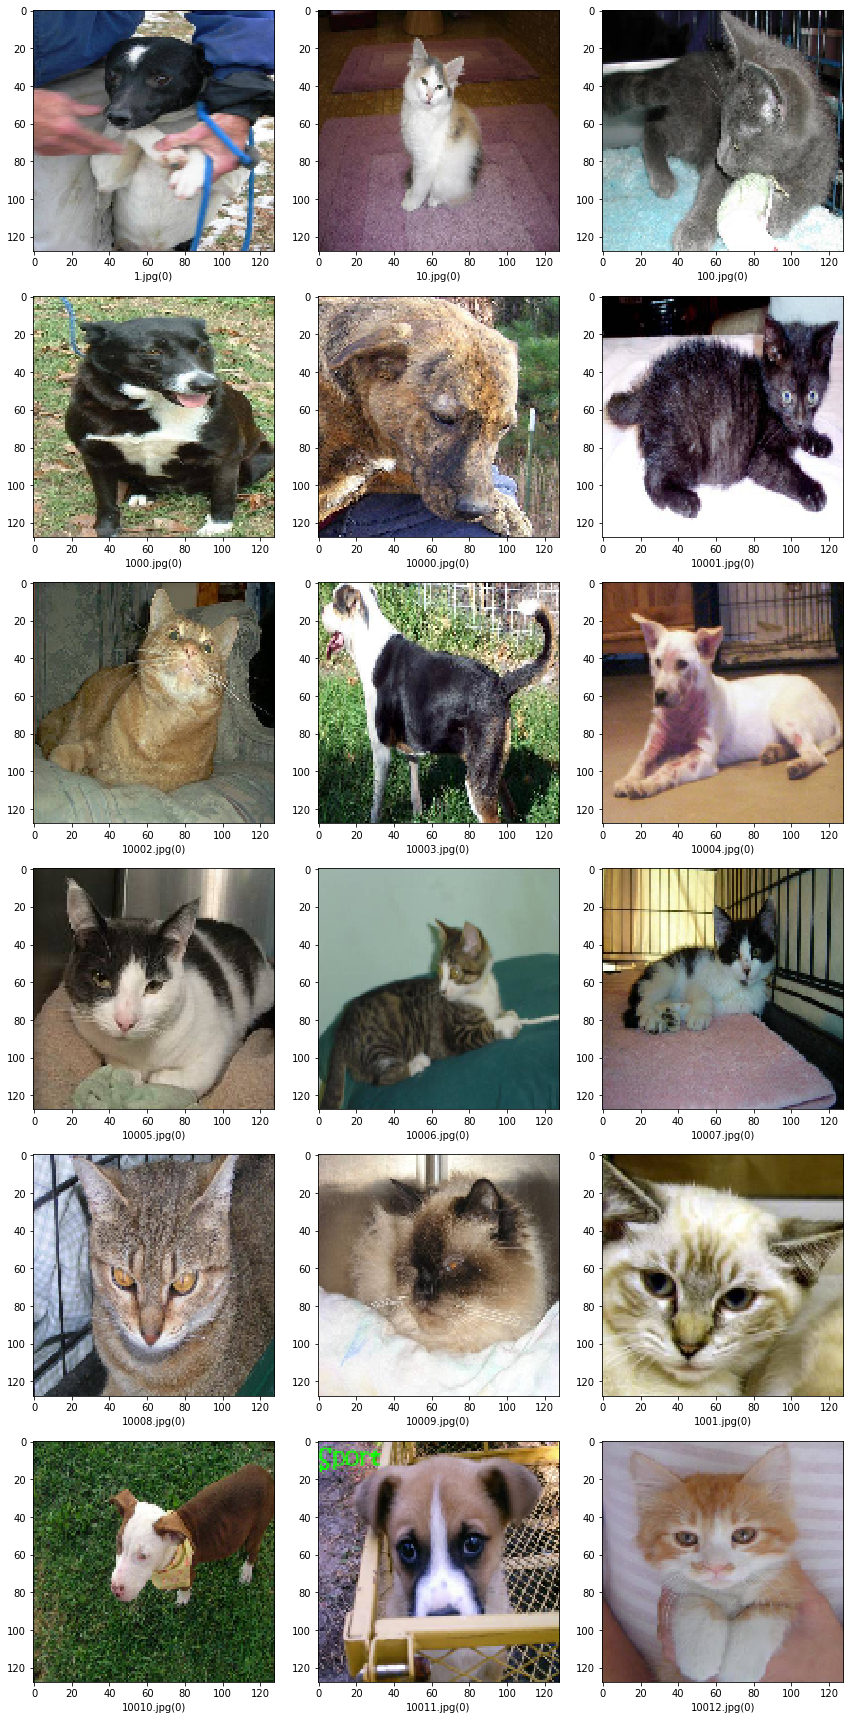

In [19]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize = (12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\CatsVsDogs\\catsvsdogs_images\\test1\\"+filename, target_size = image_size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [20]:
predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

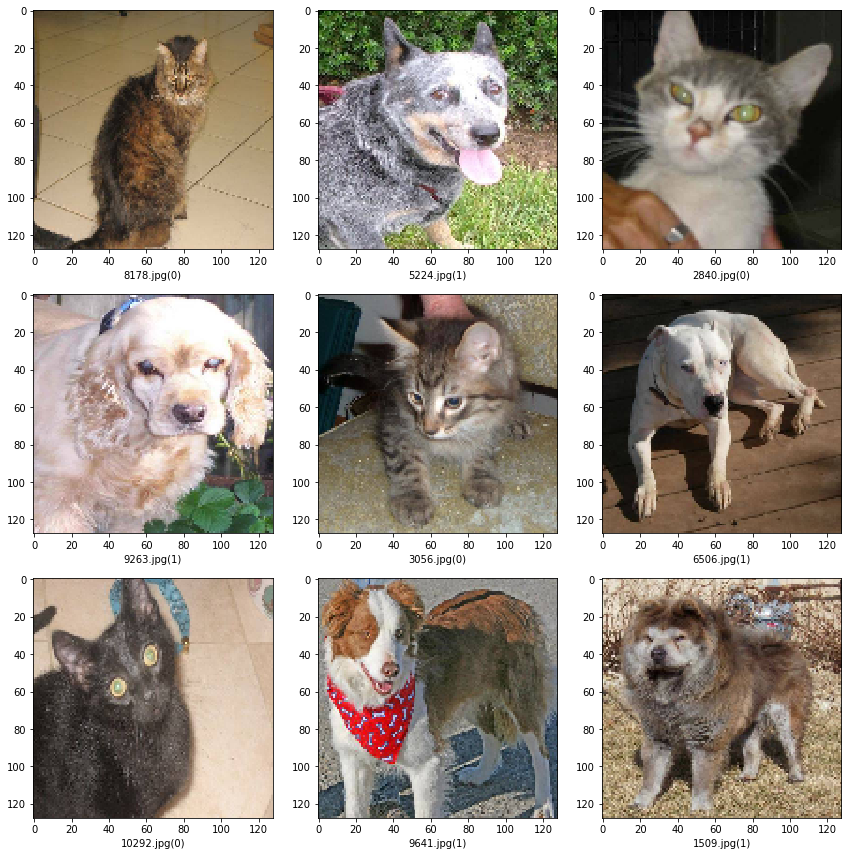

In [21]:
sample_test = test_df.sample(n = 9).reset_index()
sample_test.head()
plt.figure(figsize = (12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\CatsVsDogs\\catsvsdogs_images\\test1\\"+filename, target_size = (128, 128))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

In [22]:
predicted_class_indices = np.argmax(predict,axis = 1)
len(predicted_class_indices)
predicted_class_indices[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

C:\Users\Admin\Desktop\Research\Datasets Used\CatsVsDogs\catsvsdogs_images\test1\10001.jpg


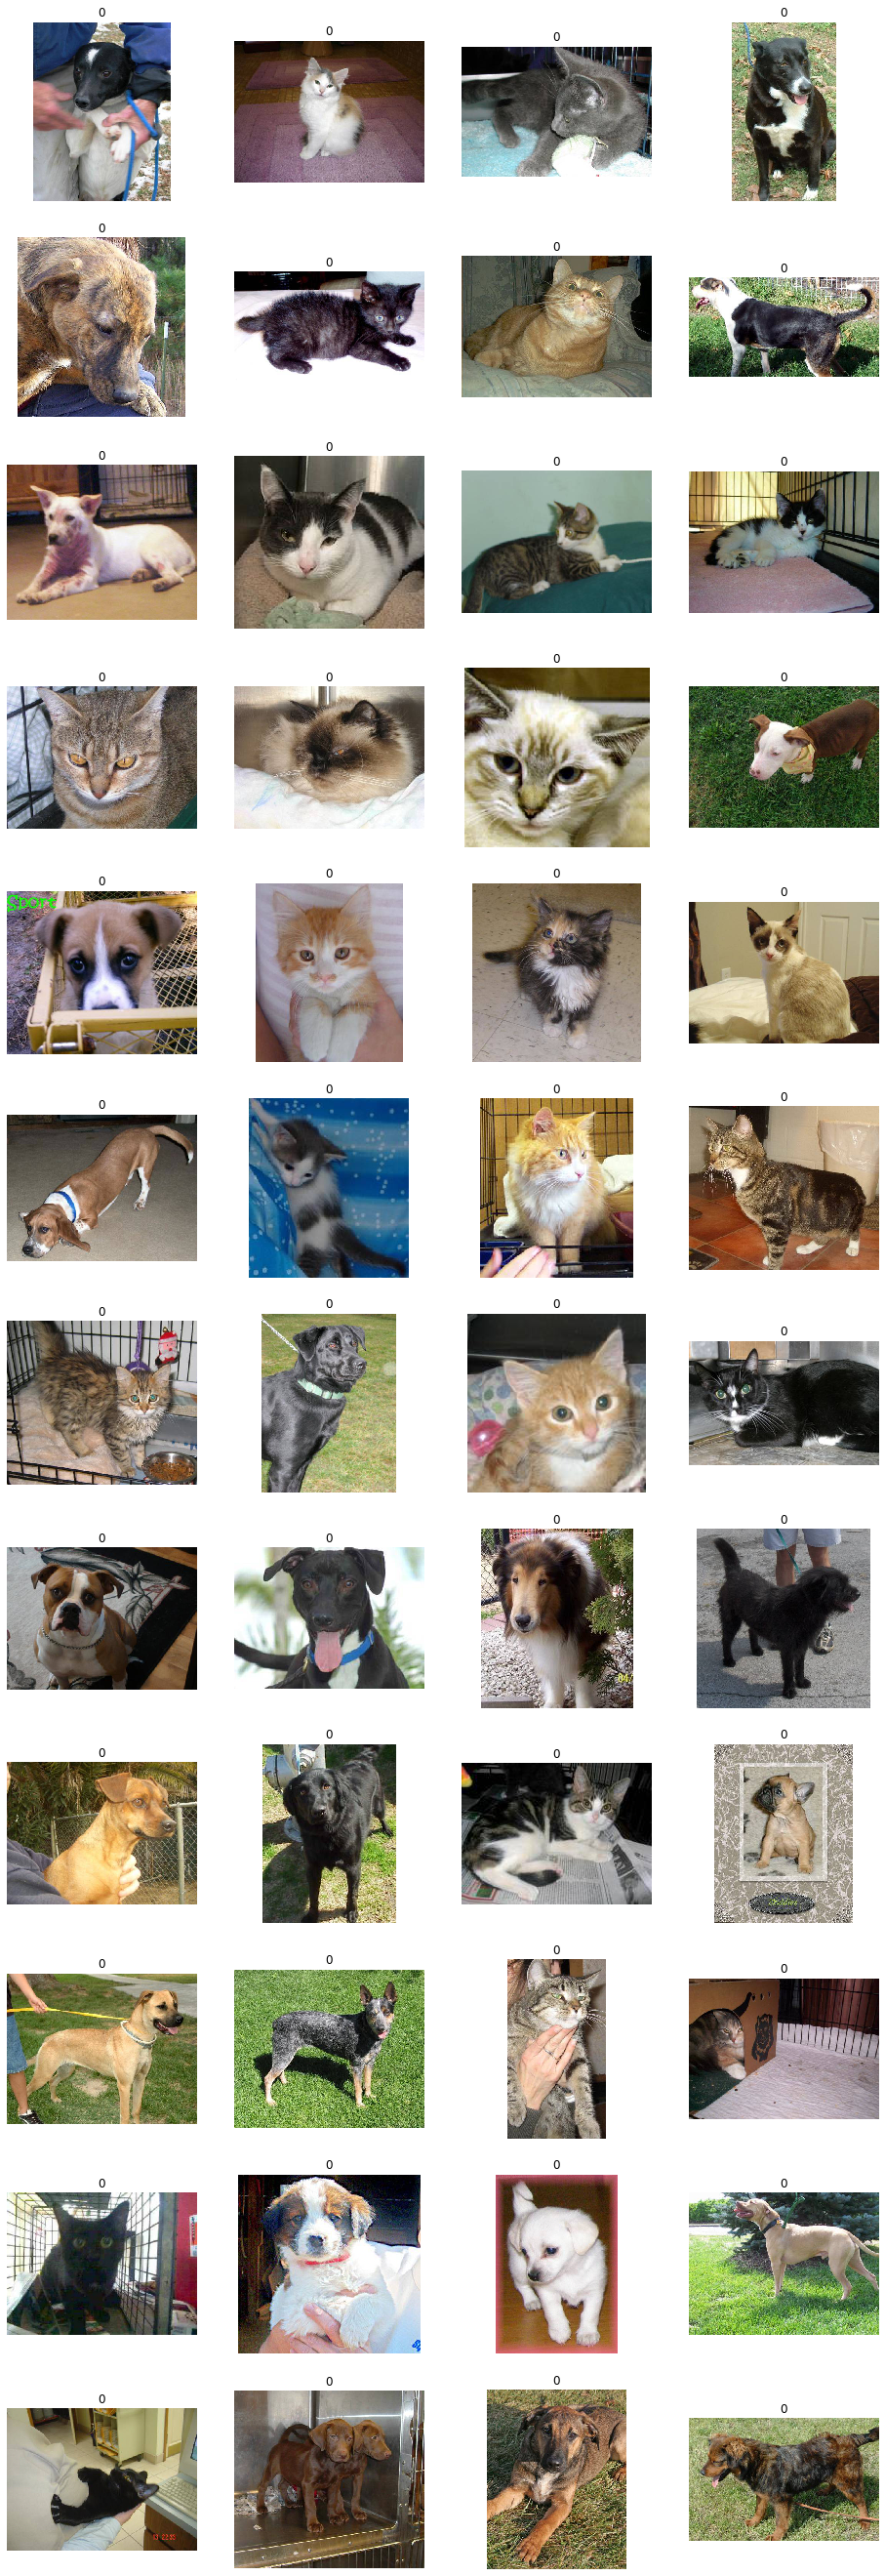

In [23]:
test_path_array = []

testpath = "C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\CatsVsDogs\\catsvsdogs_images\\test1\\"
for file in os.listdir(testpath):
   
    test_path_array.append(os.path.join(testpath,file))

print(test_path_array[5])

dtest = {'path': test_path_array}
df_test = pd.DataFrame(data = dtest)
df_test.head()

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows = 12
ncols = 4

pic_index = 0 # Index for iterating over images
# Setting up matplotlib fig and size to fit 4x4 images
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for i, img_path in enumerate(df_test.path[:48]):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.title(str(predicted_class_indices[i]))

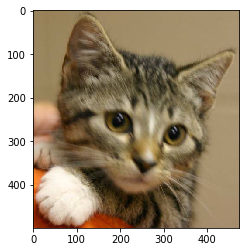

In [24]:
#Filter Visualisation setup
from keras.preprocessing import image
import matplotlib.pyplot as plt

input_image_path = 'C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\CatsVsDogs\\catsvsdogs_images\\test1\\156.jpg'

#Input Image for feature visualization
img1 = image.load_img(input_image_path)
plt.imshow(img1);

img_size = (128, 128)
#Load image into a 4D Tensor, convert it to a numpy array and expand to 4 dim's
img1 = image.load_img(input_image_path, target_size = img_size)
image_tensor = image.img_to_array(img1)
#print(image_tensor.shape)
image_tensor = image_tensor/255
image_tensor = np.expand_dims(image_tensor, axis = 0)
#print(img.shape)

In [25]:
from keras import models

#Extracts the top 8 layers
layer_outputs = [layer.output for layer in model.layers[:9]]

#Create a model that returns these outputs given the model inputs
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)

In [26]:
#Extract feature activations
activations = activation_model.predict(image_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 128, 128, 3)


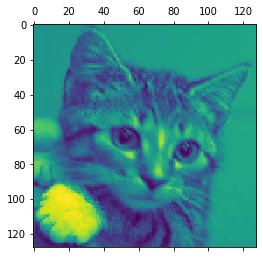

In [27]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')

In [28]:
layer_names = []
for layer in model.layers[:21]:
    layer_names.append(layer.name)
images_per_row = 16

#Use convolutional layers only
conv_layer_names = []
for layer_name in layer_names:
    if 'conv2d' in layer_name:
        conv_layer_names.append(layer_name)

for layer_name, layer_activation in zip(conv_layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
            row * size : (row + 1) * size] = channel_image
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')